# **Finding Lane Lines on the Road** 
January 29, 2020 - John Robinson

[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

**Project 1** in Udacity’s Self-Driving Car Nanodegree

My Project Repository: https://github.com/johnrobinsn/CarND-LaneLines-P1

Project Rubric: https://review.udacity.com/#!/rubrics/322/view

    When we drive, we use our eyes to decide where to go. The lines on the road that show us where the lanes are act as our constant reference for where to steer the vehicle. Naturally, one of the first things we would like to do in developing a self-driving car is to automatically detect lane lines using an algorithm.

    In this project you will detect lane lines in images using Python and OpenCV. OpenCV means “Open-Source Computer Vision”, which is a package that has many useful tools for analyzing images.
    
My Project Writeup: https://github.com/johnrobinsn/CarND-LaneLines-P1/blob/master/README.md

More about the nanodegree program: https://www.udacity.com/drive

 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />

## Import Packages

In [25]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#np_frame = video.get_frame(2) # get the frame at t=2 seconds
#np_frame = video.get_frame(frame_number * video_fps) # get frame by index
#video.save_frame('my_image.jpeg', t=2) # save frame at t=2 as JPEG

## Read in an Image

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [26]:
import math

def hls_colorspace(img):
    cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)                

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [27]:
import os
os.listdir("test_images/")

['challenge_6sec.jpg',
 'solidYellowCurve.jpg',
 'challenge_4sec.jpg',
 'challenge_8sec.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'challenge_10sec.jpg',
 'challenge_7sec.jpg',
 'challenge_5sec.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [28]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# globals used to store lane line coefficients across video frame boundaries
glma = []
glba = []
grma = []
grba = []

def clear_line_cache():
    global glma
    global glba
    global grma
    global grba
    glma = []
    glba = []
    grma = []
    grba = []

def show_lines(image, stage="final", use_line_cache=False):
    
    # nested function used by show_lines
    def analyze_lines(img, lines, color=[255, 0, 0], thickness=2):
        """
        NOTE: this is the function you might want to use as a starting point once you want to 
        average/extrapolate the line segments you detect to map out the full
        extent of the lane (going from the result shown in raw-lines-example.mp4
        to that shown in P1_example.mp4).  

        Think about things like separating line segments by their 
        slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
        line vs. the right line.  Then, you can average the position of each of 
        the lines and extrapolate to the top and bottom of the lane.

        This function draws `lines` with `color` and `thickness`.    
        Lines are drawn on the image inplace (mutates the image).
        If you want to make the lines semi-transparent, think about combining
        this function with the weighted_img() function below
        """

        #global use_line_cache
        global glma
        global glba
        global grma
        global grba

        imgshape = img.shape
        midx = int(imgshape[1]/2)
        midy = int(imgshape[0]/2)
        marginy = int(midy*0.3)
        midy = midy + marginy

        #lm = rm = 0
        #lb = rb = 0
        #lcount = rcount = 0

        lma = []
        lba = []
        rma = []
        rba = []

        for line in lines:
            for x1,y1,x2,y2 in line:
                # orient all lines from left to right
                if x2 < x1:  #flip
                    t = x1
                    x1 = x2
                    x2 = t
                    t = y1
                    y1 = t
                    y2 = t
                m = (y2-y1)/(x2-x1)
                b = y1-(m*x1)  # y intercept

                # filter for potential left lane lines
                # all lines must begin and end left of the mid point and
                # have an appropriate slope
                if x1 < midx and x2 < midx and m < -0.5 and m > -1.5:
                    # enable drawing line segments classified as left land line candidates
                    #cv2.line(img, (x1, y1), (x2, y2), [0,0,255], thickness)
                    lma.append(m)
                    lba.append(b)
                # filter for potential right lane lines
                # all lines must begin and end right of the mid point and
                # have an appropriate slope
                elif x1 > midx and x2 > midx and m > 0.5 and m < 1.5:
                    # enable drawing line segments classified as right lane line candidates
                    #cv2.line(img, (x1, y1), (x2, y2), [255,0,255], thickness)
                    rma.append(m)
                    rba.append(b)
                # enable drawing rejected lines for debugging
                #else:
                    #cv2.line(img, (x1, y1), (x2, y2), [0,255,0], 2)


        if not use_line_cache:
            glma = []
            glba = []
            grma = []
            grba = []

        # from the left lane line candidates calculate the most likely location for the left land line
        if len(lma) > 0:
            # use the median to better eliminate outliers
            lm = np.median(np.array(lma))
            lb = np.median(np.array(lba))

            glma.append(lm)
            glba.append(lb)
            
        # from the right lane line candidates calculate the most likely location for the right land line
        if len(rma) > 0:
            # use the median to better eliminate outliers
            rm = np.median(np.array(rma))
            rb = np.median(np.array(rba))

            grma.append(rm)
            grba.append(rb)
            
        # calculate the averaged left lane lines over n frames (different calls to show_lines)
        # and actually draw the line
        # use last n samples            
        glma = glma[-10:]
        glba = glba[-10:]

        if len(glma) > 0:
            lm = np.mean(np.array(glma))
            lb = np.mean(np.array(glba))

            y1 = midy
            x1 = int((y1-lb)/lm)
            y2 = imgshape[0]
            x2 = int((y2-lb)/lm)

            cv2.line(img, (x1, y1), (x2, y2), [255,0,0], 7)

        # calculate the averaged right lane lines over n frames (different calls to show_lines)
        # and actually draw the line
        # use last n samples
        grma = grma[-10:]
        grba = grba[-10:]
        
        if len(grma) > 0:
            rm = np.mean(np.array(grma))
            rb = np.mean(np.array(grba))

            y1 = midy
            x1 = int((y1-rb)/rm)
            y2 = imgshape[0]
            x2 = int((y2-rb)/rm)

            cv2.line(img, (x1, y1), (x2, y2), [255,0,0], 7)

    # nested function used by show_lines
    def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
        """
        `img` should be the output of a Canny transform.

        Returns an image with hough lines drawn.
        """
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        analyze_lines(line_img, lines, thickness=2)
        return line_img
    
    if stage == "image":
        return image

    
    # ==== yellow_removed stage
    # Yellow lane lines prevent a bit of a challenge when on a concrete surface
    # their lower contrast against this background doesn't allow for robust detection
    # under different lighting conditions.  In order to address this I identify the yellow
    # pixels in the image and change those pixels to white.
    
    # First convert to the HLS colorspace so we can use the Hue component to identify yellow pixels
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # HLS ranges for selecting Yellow; values found through experimentation
    # H value (see HLS color space) opencv uses a range of 0-180 for hue
    # L value opencv uses a range of 0-255 for lightness
    # S value opencv uses a range of 0-255 for saturation
    yellow_lower = np.array([10, np.round(0.3 * 255), np.round(0.3 * 255)])
    yellow_upper = np.array([70, np.round(0.9 * 255), np.round(1.00 * 255)])
    
    # Use inRange to generate a mask that identifies all yellow pixels
    yellow_mask = cv2.inRange(hls, yellow_lower, yellow_upper)

    yellow_removed = image.copy()
    
    # make all yellow pixels identified in yellow_mask white
    yellow_removed[yellow_mask>0] = [255,255,255]
    
    
    if stage == "yellow_removed": # for debugging
        return yellow_removed
    
    # === grayscale stage
    # Convert to grayscale for further image analysis
    
    gray = grayscale(yellow_removed)
    
    if stage == "grayscale": #for debugging
        return np.dstack((gray,gray,gray))
    
    # === blurred stage
    # Use gaussian blur to smooth out noise across adjacent pixels
    blurred = gaussian_blur(gray, 5)
    
    if stage == "blurred": # for debugging
        return np.dstack((blurred,blurred,blurred))
    
    # === canny stage
    # Use canny filter to find edges
    low_threshold = 50
    high_threshold = 150
    canny = cv2.Canny(blurred, low_threshold, high_threshold)
    
    if stage == "canny":  # for debugging
        return np.dstack((canny,canny,canny))
    
    imshape = canny.shape
    midx = int(imshape[1]/2)
    marginx = int(midx*0.1)
    midy = int(imshape[0]/2)
    marginy = int(midy*0.2)
    marginbot = 0
    
    vertices = np.array([[(0,imshape[0]-marginbot),(midx-marginx, midy+marginy), (midx+marginx, midy+marginy), (imshape[1],imshape[0]-marginbot)]], dtype=np.int32)
    region = region_of_interest(canny, vertices )
    
    if stage == "region":  # for debugging
        return np.dstack((region,region,region))
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length =40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments

    hough = hough_lines(region, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Uncomment to show outline of masked region 
    #cv2.polylines(hough, vertices, True, color=[0,0,255], thickness=2)
    
    weighted = weighted_img(hough, image)
    return weighted

def show_lines_in_file(f):
    
    image = mpimg.imread(f)

    #printing out some stats and plotting
    #print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.figure()
    plt.title(os.path.basename(f))
    plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    
    result = show_lines(image)
    
    plt.figure()
    plt.imshow(result, cmap='gray')

In [29]:
def show_image_grid(images, stage="final"):
    f, ax = plt.subplots(len(images),3,sharex=True,sharey=True,figsize=(15,45))

    for i in range(len(images)):
        image = plt.imread(image_dir+images[i])
        ax[i,1].axis("off")
        ax[i,2].axis("off")
        ax[i,0].set_ylabel(os.path.splitext(os.path.basename(images[i]))[0])
        ax[i,0].set(frame_on=False)
        ax[i,0].imshow(image)
        ax[i,1].imshow(show_lines(image, stage=stage))
        ax[i,2].imshow(show_lines(image))
    f.subplots_adjust(wspace=0, hspace=0)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [30]:
# Utility function to extract frames from a video and look for lane lines
# First column is the original frame, second column is an interstitial frame
# third column is the final image with lane markers

def show_video_grid(video, start = 0, stop = 10, stage="final"):
    
    video = VideoFileClip(video)
    
    duration = video.duration
    start = max(min(duration, start),0)
    stop = max(min(duration, stop), 0)
    num = stop-start+1
    
    f, ax = plt.subplots(num,3,sharex=True,sharey=True,figsize=(15,45))

    for i in range(start,stop+1):
        image = video.get_frame(i)
        ax[i,1].axis("off")
        ax[i,2].axis("off")
        ax[i,0].set_ylabel(str(i)+"s")
        ax[i,0].set(frame_on=False)
        ax[i,0].imshow(image)
        ax[i,1].imshow(show_lines(image, stage=stage))
        ax[i,2].imshow(show_lines(image))

    f.subplots_adjust(wspace=0, hspace=0)
    plt.xticks([])
    plt.yticks([])
    plt.show()

#### Shows individual processed frames from the specified video at 1s intervals

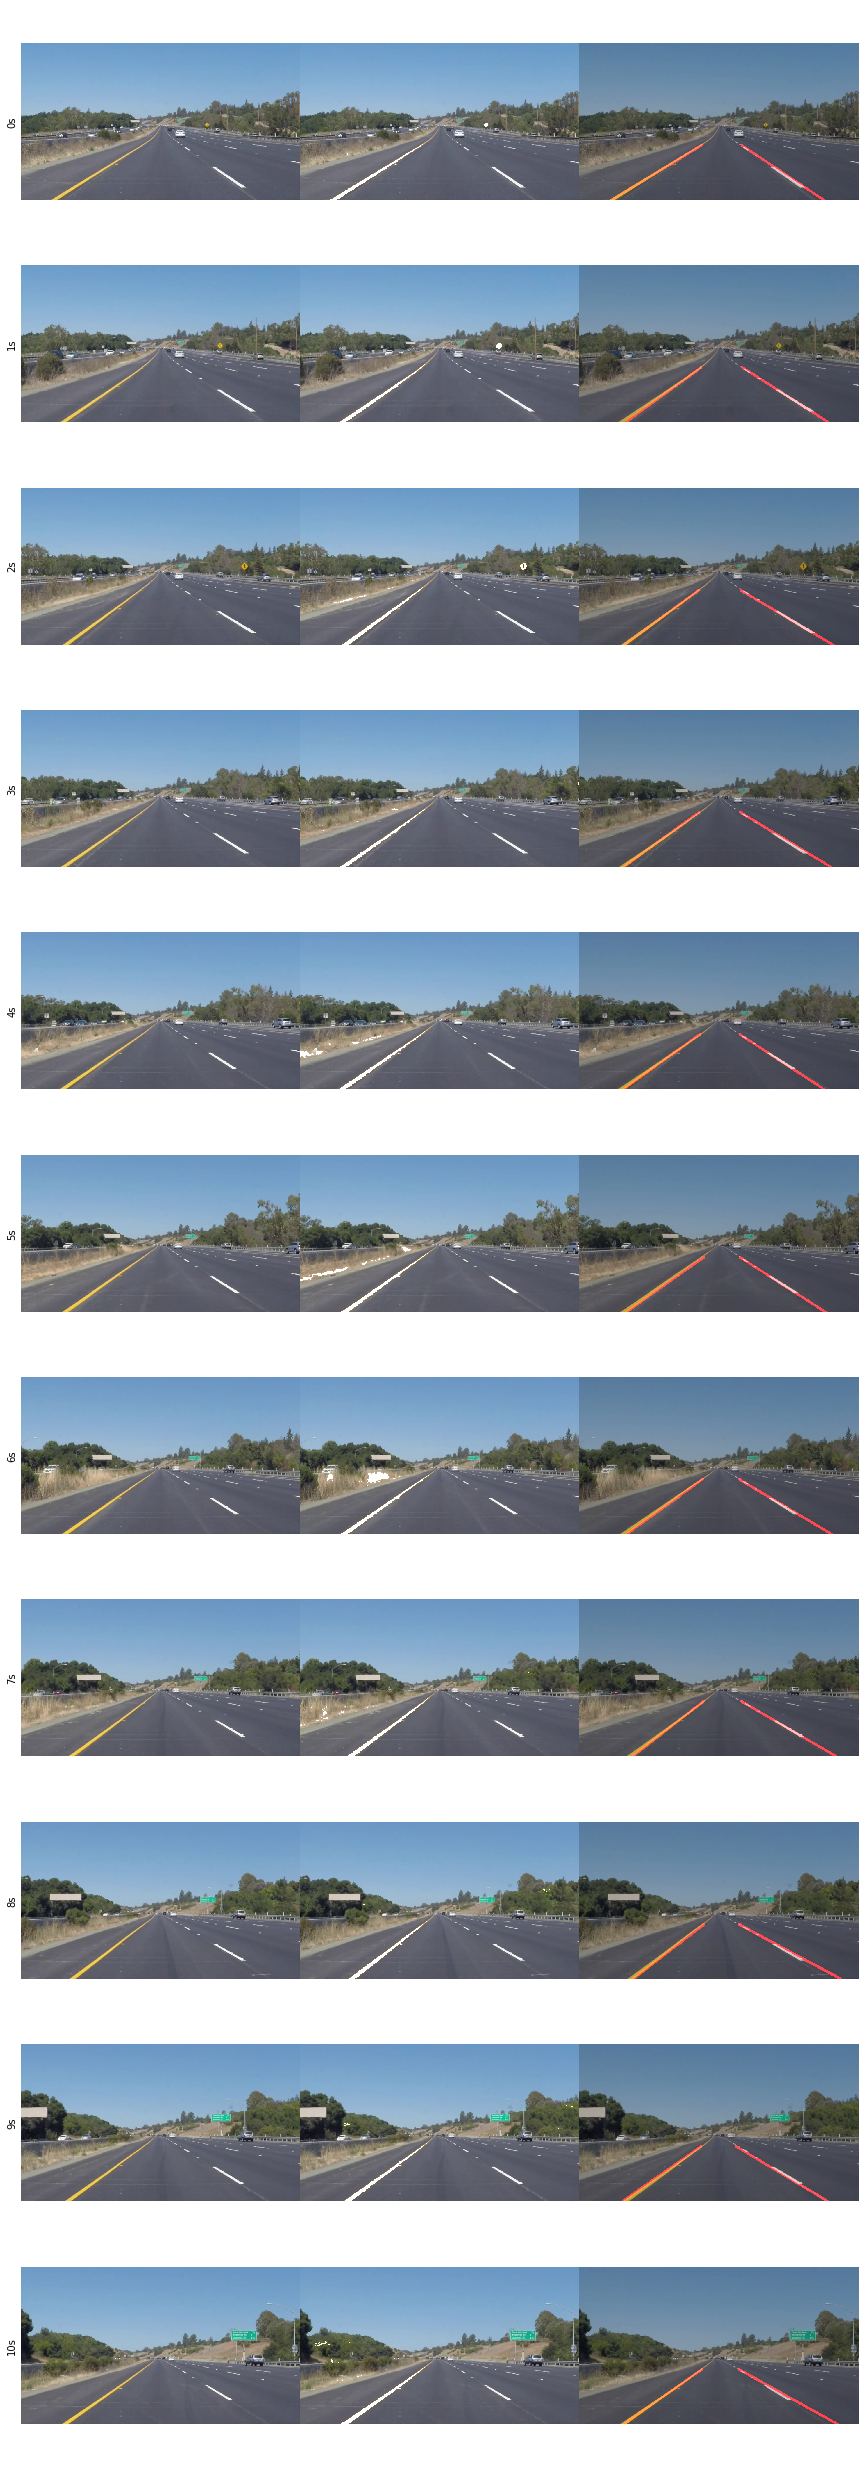

In [31]:
show_video_grid('test_videos/solidYellowLeft.mp4', stage="yellow_removed")

#### Shows the lane line output on the provided test images and some of the more interesting frames from the challenge video

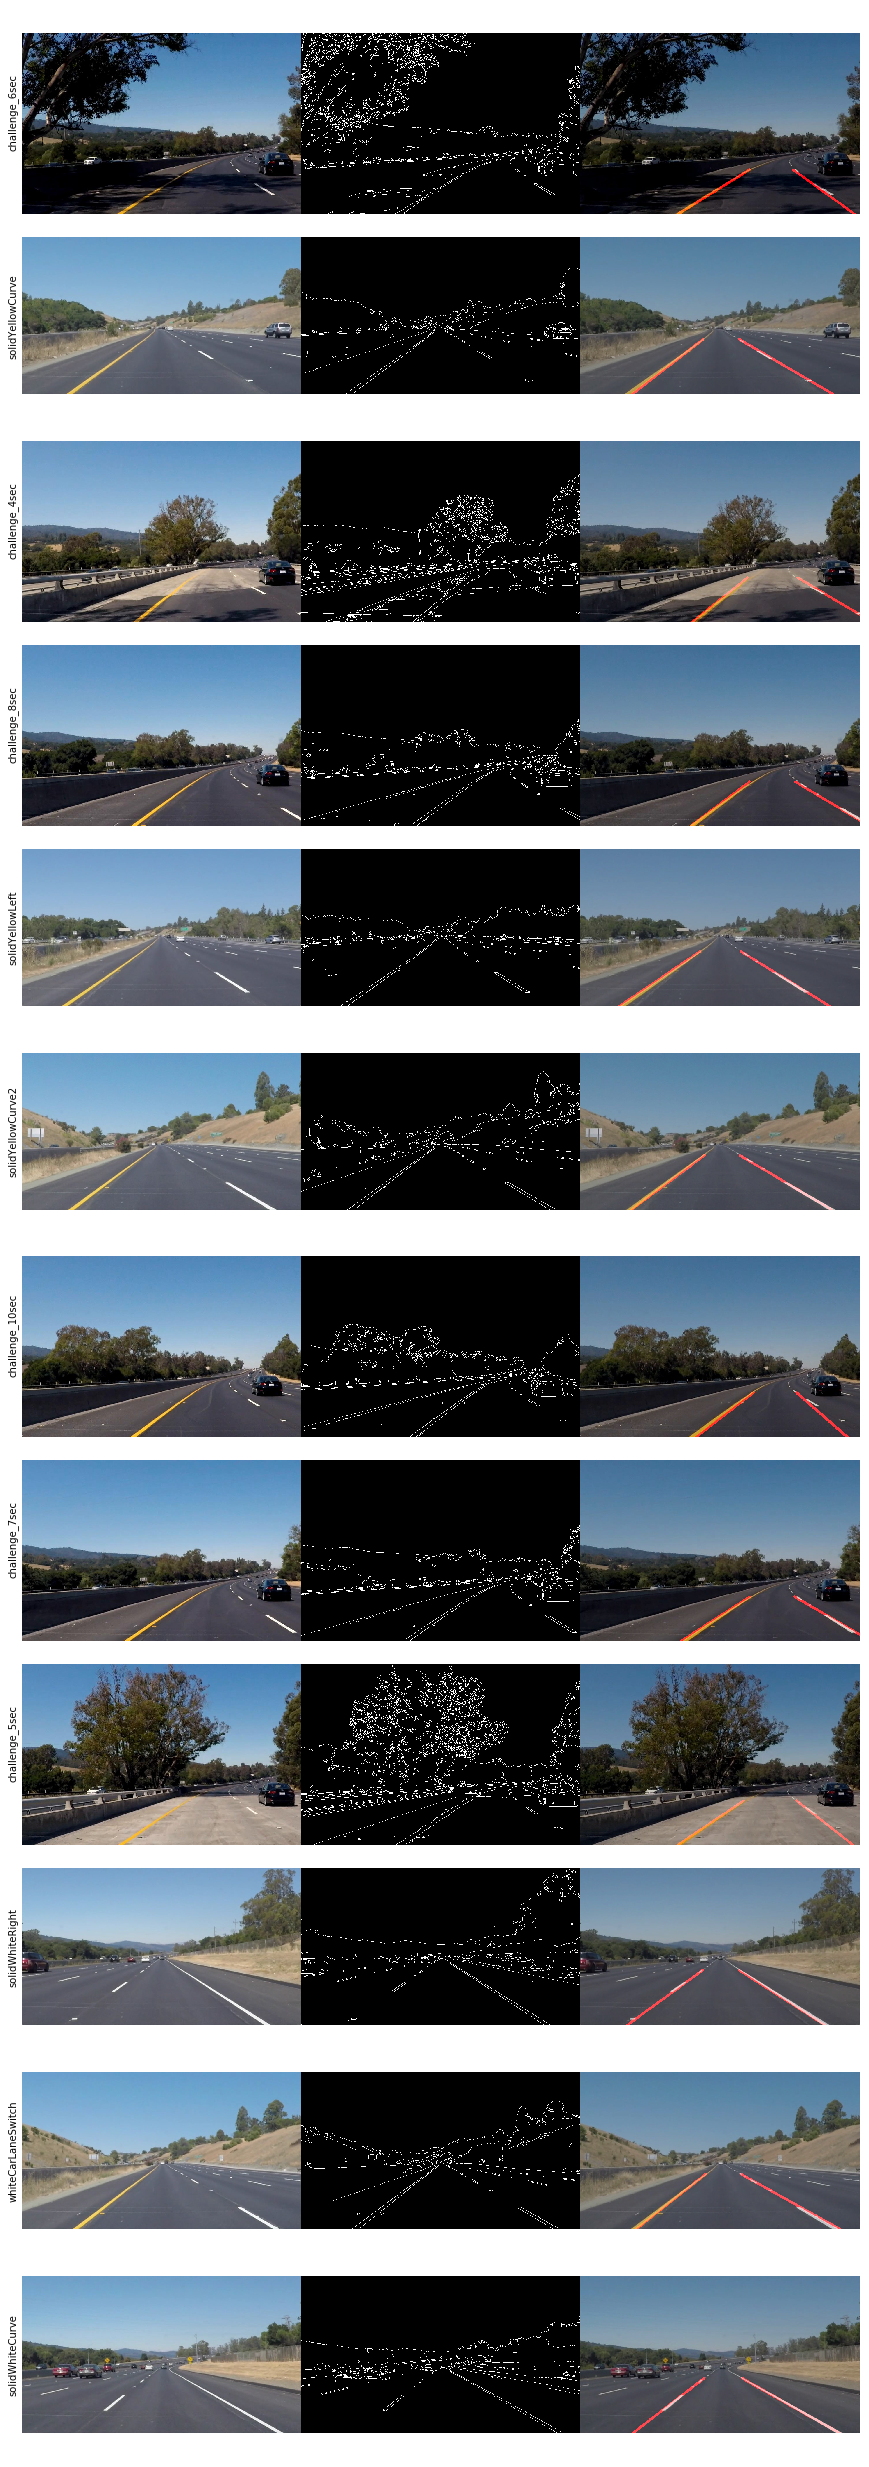

In [32]:
image_dir = "test_images/"
images = os.listdir(image_dir)

show_image_grid(images, stage="canny")


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [33]:
# This function can be used to get the pipeline processing function in such a way that the lane lines
# will be averaged across the last ten frames when processing video.
def get_image_processor():
    clear_line_cache()
    def process_image(image):
        # invoke pipeline but utilize the line cache to average lane line calculations
        # across video frames
        return show_lines(image, use_line_cache=True)
    
    return process_image

Let's try the one with the solid white lane on the right first ...

In [34]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(get_image_processor()) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 49.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.48 s, sys: 668 ms, total: 5.14 s
Wall time: 4.91 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [36]:

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(get_image_processor())
%time yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:14<00:00, 46.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 13.9 s, sys: 1.88 s, total: 15.7 s
Wall time: 15 s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

#### The same video at 1s intervals with the image processing shown

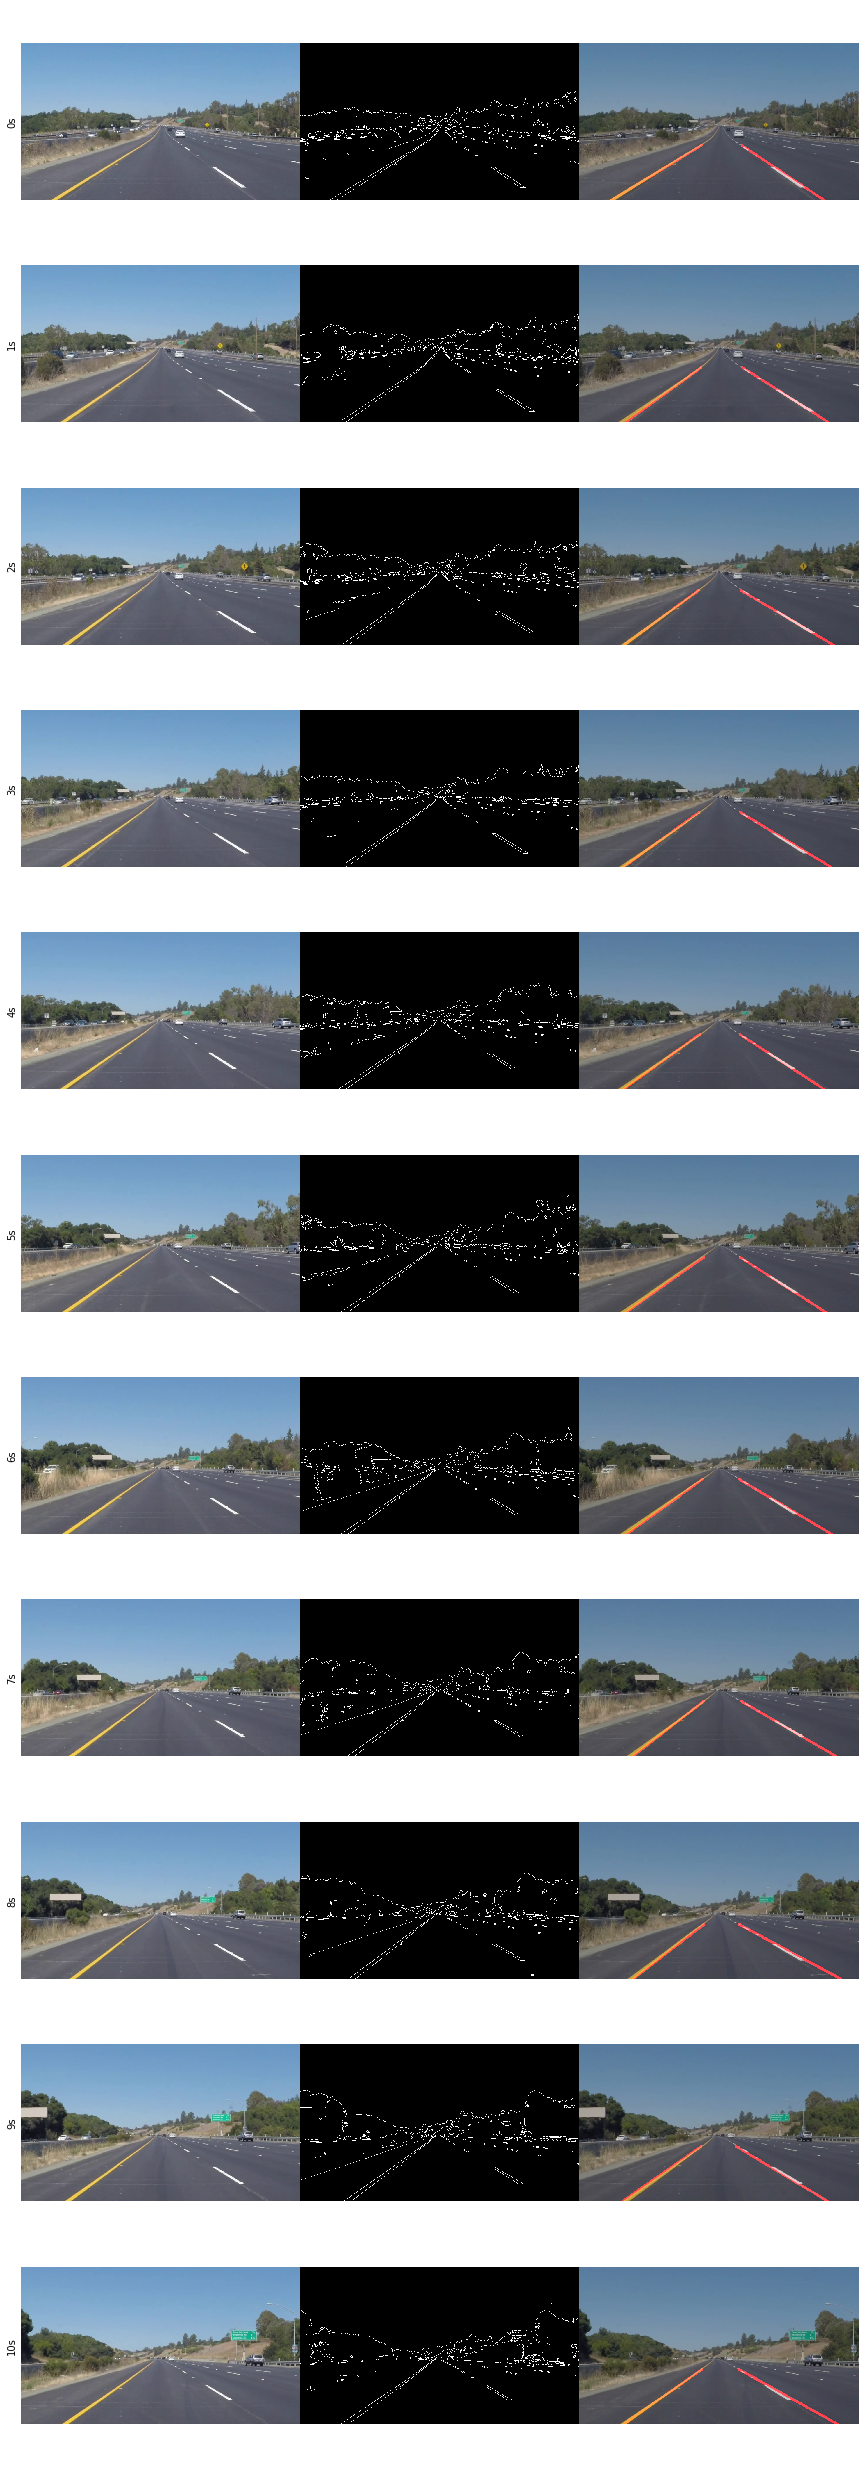

In [38]:
show_video_grid('test_videos/solidYellowLeft.mp4', stage="canny")

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [39]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(get_image_processor())
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:09<00:00, 28.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 8.03 s, sys: 893 ms, total: 8.92 s
Wall time: 10 s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Optional Challenge Second by Second Analysis
* Show intermediate stage with canny edge filtering with area of region masking.
* Show final stage

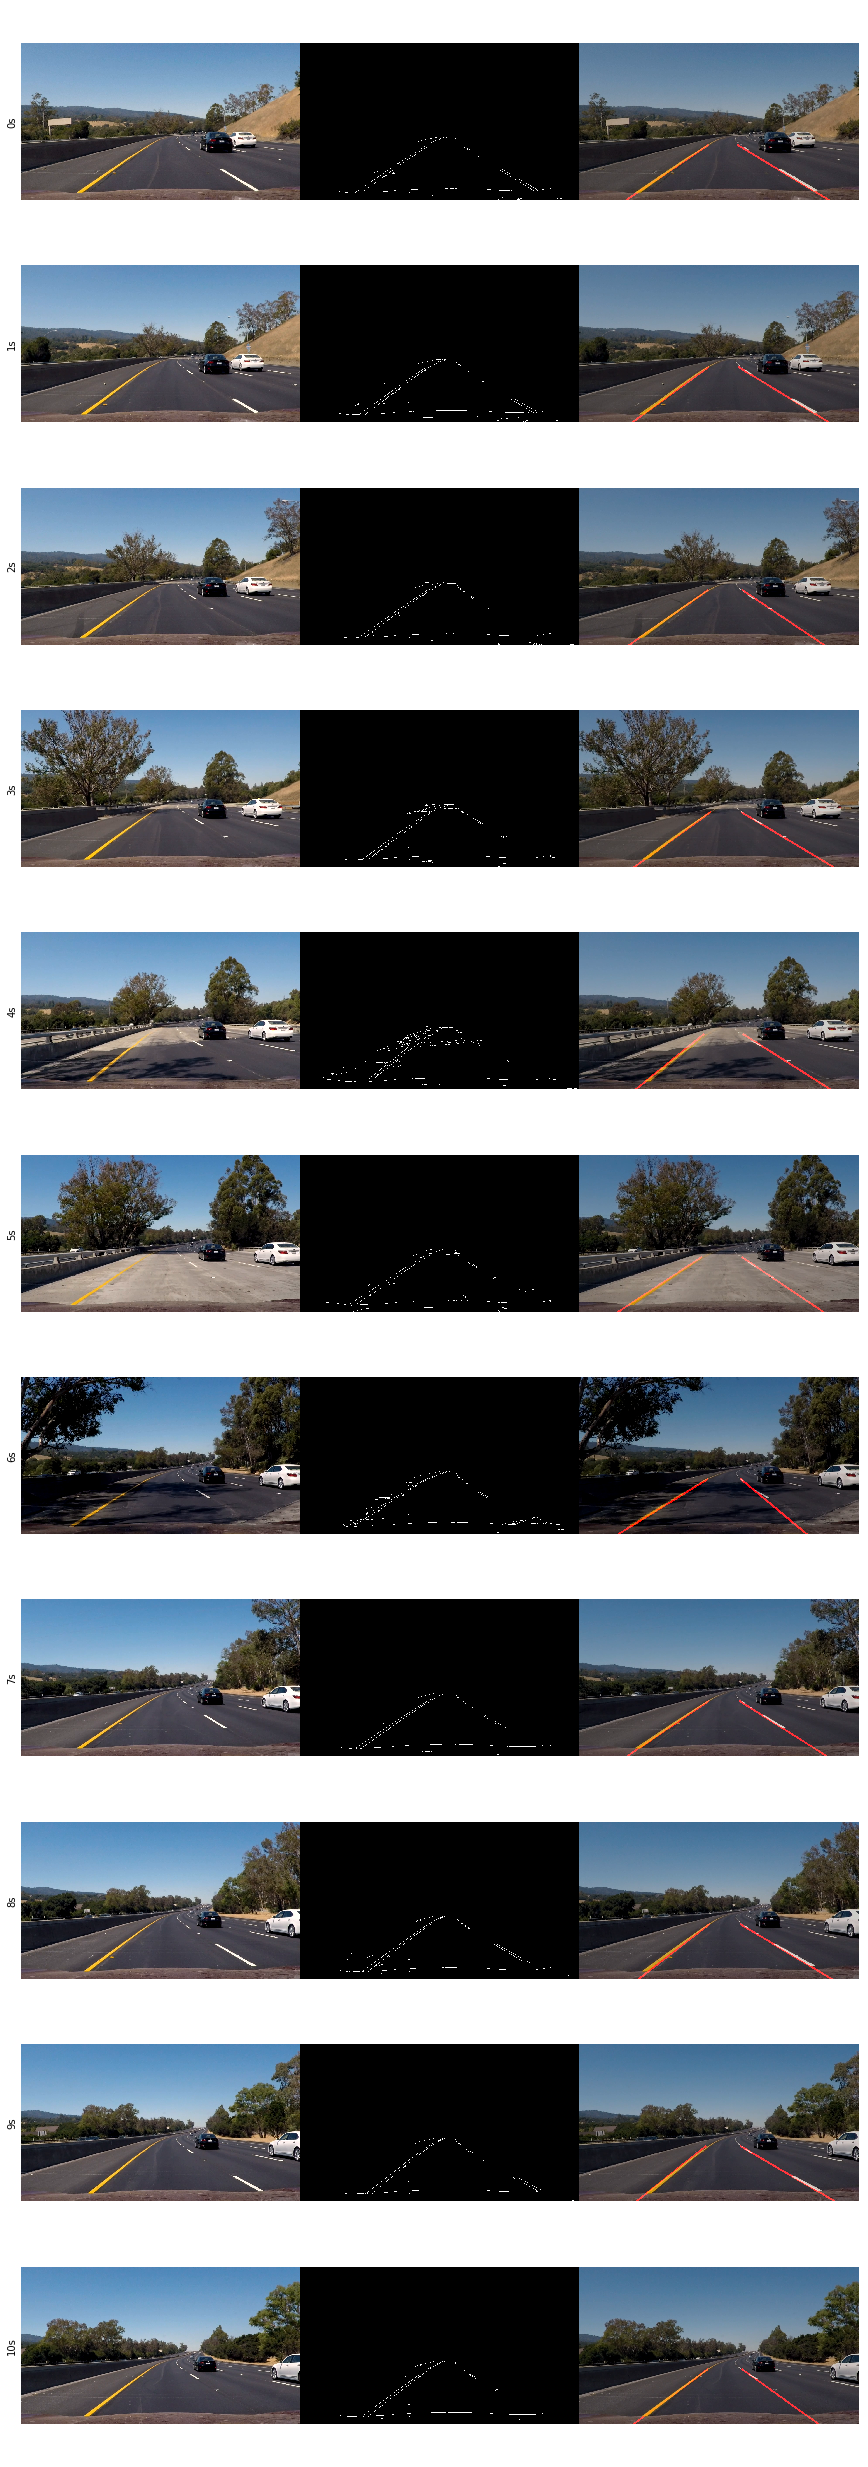

In [41]:
show_video_grid('test_videos/challenge.mp4', stage="region")